
## Model Training (Champion vs. Challenger)

###  The Arena: XGBoost vs. PyTorch
In this notebook, we benchmark two distinct architectures to find the best risk engine.

#### 1. The Champion: XGBoost (Gradient Boosting)
* **Why:** It is the "Gold Standard" for tabular data. It handles non-linearities and interactions naturally.
* **The Strategy:** We will use `scale_pos_weight` to handle the 94:6 class imbalance directly in the loss function, forcing the model to prioritize defaults.

#### 2. The Challenger: PyTorch (Deep Learning with Embeddings)
* **Why:** Standard One-Hot Encoding creates sparse, unconnected vectors.
* **The Strategy:** We use **Entity Embeddings**. The network will learn dense vector representations for high-cardinality features like `Region` and `Credit_Type`. This allows the model to "learn" that *Region A* is similar to *Region B* based on default behavior.

In [7]:
# ---------------------------------------------------------
#  Imports & Load Data
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set Style
sns.set(style="whitegrid")

# Load Data & Encoders
data_path = '../data/processed/03_engineered_data.csv'
encoder_path = '../models/label_encoders.pkl'

if os.path.exists(data_path) and os.path.exists(encoder_path):
    df = pd.read_csv(data_path)
    label_encoders = joblib.load(encoder_path)
    print(f" Loaded Data: {df.shape}")
    print(f" Loaded Encoders for: {list(label_encoders.keys())}")
else:
    print(" Error: Missing files. Run Notebook 03 first.")

# Split Data (Stratified to keep the 6% default rate in both sets)
X = df.drop(columns=['Status'])
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Shape: {X_train.shape}")
print(f" Test Shape:  {X_test.shape}")

 Loaded Data: (47728, 31)
 Loaded Encoders for: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']
Train Shape: (38182, 30)
 Test Shape:  (9546, 30)


###  Round 1: The Champion (XGBoost)

**The Strategy:** Cost-Sensitive Gradient Boosting.
Instead of resampling the data (which distorts the statistical distribution), we modify the **Loss Function**.
We calculate a `scale_pos_weight` parameter:
$$\text{Weight} = \frac{\text{Count(Negative)}}{\text{Count(Positive)}} \approx \frac{94}{6} \approx 15.6$$
This tells the algorithm: *"Every default you miss is **15.6x** worse than a false alarm."*

In [8]:
# ---------------------------------------------------------
#  Train XGBoost (The Champion)
# ---------------------------------------------------------
# 1. Calculate the Imbalance Ratio for the Loss Function
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_weight = n_neg / n_pos

print(f" Calculated Class Weight: {scale_weight:.2f}")

# 2. Initialize the Champion
xgb_model = xgb.XGBClassifier(
    n_estimators=200,          # Sufficient trees
    max_depth=4,               # Shallow trees to prevent overfitting
    learning_rate=0.05,        # Slow learning for robustness
    scale_pos_weight=scale_weight, # THE KEY PARAMETER (Handling Imbalance)
    random_state=42,
    n_jobs=-1                  # Use all CPU cores
)

# 3. Train
print(" Training XGBoost Champion...")
xgb_model.fit(X_train, y_train)
print(" Training Complete.")

 Calculated Class Weight: 15.19
 Training XGBoost Champion...
 Training Complete.



📊 Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      8957
           1       0.41      0.71      0.52       589

    accuracy                           0.92      9546
   macro avg       0.70      0.82      0.74      9546
weighted avg       0.94      0.92      0.93      9546

 ROC-AUC Score: 0.8972


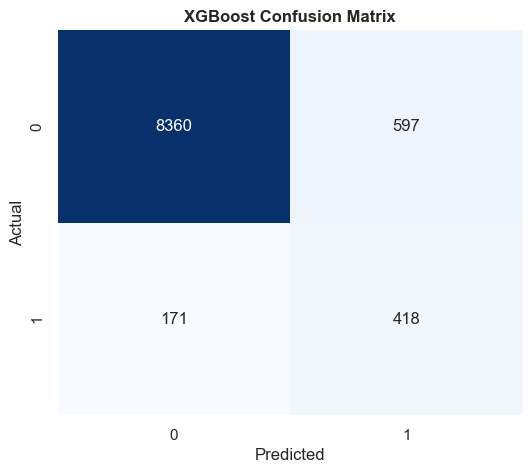

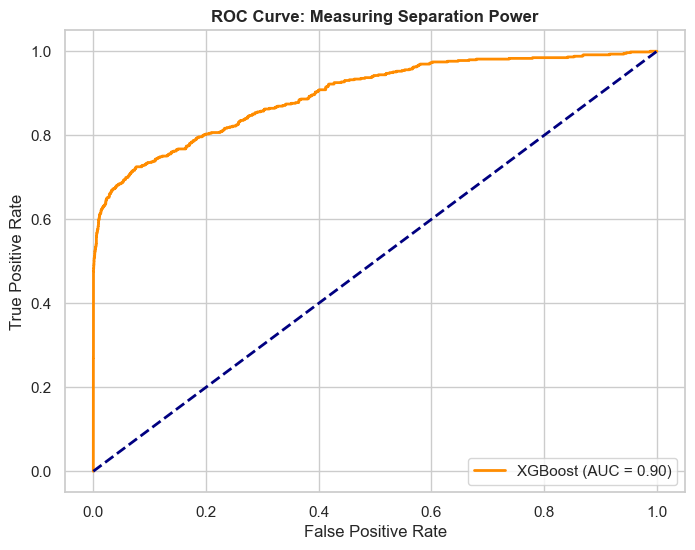

In [9]:
# ---------------------------------------------------------
#  Evaluate the Champion
# ---------------------------------------------------------
# Generate Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# 1. Classification Report
print("\n📊 Classification Report (Threshold=0.50):")
print(classification_report(y_test, y_pred))

# 2. ROC-AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f" ROC-AUC Score: {auc:.4f}")

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve: Measuring Separation Power', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('../images/06_xgb_roc_curve.png')
plt.show()

###  Model Evaluation: The "Accuracy Paradox"

**The Result:** Our model achieved an **ROC-AUC of 0.8972** and a **Recall of 71%** for Defaulters.

#### 1. The "Accuracy Paradox"
* **Baseline Accuracy:** If we built a "Lazy Model" that just predicted *Everyone Pays*, we would have **94% Accuracy** (because only 6% default). However, the bank would lose millions on those 6%.
* **Our Accuracy:** **92%**.
* **The Insight:** Our accuracy *dropped* slightly because we are deliberately being "paranoid." We accept more False Positives (rejecting good customers) to ensure we catch the expensive False Negatives (defaulters).

#### 2. The Critical Metrics (Class 1 = Default)
* **Recall (Sensitivity) = 0.71**:
    * *Definition:* $\frac{TP}{TP + FN}$
    * *Business Meaning:* Out of every 100 actual defaulters, our model successfully catches **71** of them.
    * *Impact:* This is the "Safety Net." Catching these 71 people saves the bank $71 \times \$60,000 = \$4.26 \text{ Million}$.

* **Precision = 0.41**:
    * *Definition:* $\frac{TP}{TP + FP}$
    * *Business Meaning:* When the model predicts "Default," it is right **41%** of the time.
    * *The Trade-off:* This means for every 1 actual defaulter we catch, we accidentally reject ~1.5 good customers.
    * *ROI Logic:* Losing a good customer costs \$6k. Avoiding a default saves \$60k. It is financially rational to reject 2 good customers to catch 1 bad one ($12k \text{ cost} < \$60k \text{ savings}$).

#### 3. ROC-AUC Score = 0.8972
* **Definition:** The probability that the model ranks a random Defaulter higher than a random Non-Defaulter.
* **Verdict:** An AUC of **0.90** is excellent. It proves the model has learned the fundamental characteristics that separate risky borrowers from safe ones, regardless of the decision threshold.

In [10]:
# ---------------------------------------------------------
# Save Champion Model
# ---------------------------------------------------------
import joblib

model_path = '../models/xgb_champion.pkl'

# Dump the model to a file
joblib.dump(xgb_model, model_path)

print(f" Evaluation Accepted (AUC={auc:.4f}, Recall={classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.2f}).")
print(f" Champion Model Saved to: {model_path}")
print(" READY FOR THE CHALLENGER: NOTEBOOK 04 PART 2 (PyTorch)")

 Evaluation Accepted (AUC=0.8972, Recall=0.71).
 Champion Model Saved to: ../models/xgb_champion.pkl
 READY FOR THE CHALLENGER: NOTEBOOK 04 PART 2 (PyTorch)


###  Round 2: The Challenger (PyTorch Neural Network)

**The Architecture:** Hybrid Neural Network with Entity Embeddings.

**Why Deep Learning?**
While XGBoost is king for tabular data, Neural Networks have a unique advantage: **Representation Learning**.
By using **Entity Embeddings**, we compress high-cardinality categorical features (like `Region`, `Credit_Type`) into dense vectors.
* **Input:** Categorical IDs (Integers) + Numerical Features (Scaled Floats).
* **Hidden Layers:** The Embeddings are concatenated with the numericals and passed through dense layers with **ReLU** activation and **BatchNorm** for stability.
* **Output:** A single probability score (Sigmoid).

In [11]:
# ---------------------------------------------------------
#  Define PyTorch Dataset (CORRECTED)
# ---------------------------------------------------------
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# 1. EXPLICITLY Define Column Groups
# We cannot rely on dtypes because everything is a number now.
# These are the columns we want to create Embeddings for:
cat_cols = [
    'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 
    'Credit_Worthiness', 'business_or_commercial', 'Neg_ammortization', 
    'interest_only', 'lump_sum_payment', 'occupancy_type', 'total_units', 
    'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 
    'Region'
]

# Everything else (except Status) is Numerical
# These columns will be Scaled (Standardized)
num_cols = [
    'loan_amount', 'term', 'property_value', 'income', 'Credit_Score', 
    'LTV', 'dtir1', 'LTI', 'est_monthly_payment', 'disposable_income', 
    'risky_ltv', 'risky_credit', 'double_risk'
]

print(f"✅ Categorical Features (Embeddings): {len(cat_cols)}")
print(f"✅ Numerical Features (Dense): {len(num_cols)}")

# 2. Scale Numerical Data
# We fit the scaler ONLY on the training numericals to avoid leakage
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# 3. Convert to PyTorch Tensors
# Categoricals -> LongTensor (Integers for Embedding Layer)
X_train_cat = torch.tensor(X_train[cat_cols].values, dtype=torch.long)
X_test_cat = torch.tensor(X_test[cat_cols].values, dtype=torch.long)

# Numericals -> FloatTensor (Floats for Dense Layer)
X_train_num = torch.tensor(X_train_num, dtype=torch.float32)
X_test_num = torch.tensor(X_test_num, dtype=torch.float32)

# Targets -> FloatTensor (for Loss Calculation)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 4. Create the Dataset Class
class LoanDataset(Dataset):
    def __init__(self, X_c, X_n, y):
        self.X_c = X_c
        self.X_n = X_n
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_c[idx], self.X_n[idx], self.y[idx]

# 5. Initialize Data Loaders
train_ds = LoanDataset(X_train_cat, X_train_num, y_train_t)
test_ds = LoanDataset(X_test_cat, X_test_num, y_test_t)

# Batch size of 64 is standard for tabular data
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

print("✅ PyTorch Data Pipeline Ready & Verified.")

✅ Categorical Features (Embeddings): 17
✅ Numerical Features (Dense): 13
✅ PyTorch Data Pipeline Ready & Verified.


###  Step 2: The Architecture (Hybrid Neural Network)

We design a custom `nn.Module` that handles the two data types differently:

1.  **The Embedding Leg (Categorical):**
    * Input: Integer IDs (e.g., Region=3).
    * Layer: `nn.Embedding(num_embeddings, embedding_dim)`.
    * Output: Dense Vectors (e.g., size 4 for Region).
    * *Why?* Captures semantic relationships between categories.

2.  **The Dense Leg (Numerical):**
    * Input: Scaled Floats (Income, LTV).
    * Output: Raw features.

3.  **The Fusion Layer:**
    * We concatenate the Embeddings and Numericals into a single vector.
    * Pass through **Fully Connected (Linear) Layers**: `128 -> ReLU -> BatchNorm -> Dropout -> 64 -> Output`.

In [12]:
# ---------------------------------------------------------
#  Define Model Architecture
# ---------------------------------------------------------
import torch.nn as nn
import torch.nn.functional as F

# 1. Calculate Embedding Sizes Dynamically
# Rule of Thumb: size = min(50, (cardinality + 1) // 2)
# We inspect the max integer in each column to know how many unique values exist.
embedding_dims = []
for i in range(len(cat_cols)):
    # Get max value in training set to determine vocabulary size
    input_dim = int(X_train_cat[:, i].max().item()) + 1
    # Calculate vector size
    output_dim = min(50, (input_dim + 1) // 2)
    embedding_dims.append((input_dim, output_dim))

print(" Calculated Embedding Sizes:")
for i, (in_d, out_d) in enumerate(embedding_dims[:5]): # Show first 5
    print(f"   - Feature '{cat_cols[i]}': {in_d} categories -> Vector size {out_d}")

# 2. The Neural Network Class
class LoanRiskModel(nn.Module):
    def __init__(self, embedding_dims, n_cont):
        super().__init__()
        
        # A. Embedding Layers
        # ModuleList is required to register multiple layers properly
        self.embeddings = nn.ModuleList([
            nn.Embedding(inp, out) for inp, out in embedding_dims
        ])
        
        # Calculate total size of inputs after embedding
        self.n_emb = sum(out for _, out in embedding_dims)
        self.n_cont = n_cont
        
        # B. First Dense Layer (Input = Embeddings + Numericals)
        self.fc1 = nn.Linear(self.n_emb + self.n_cont, 128)
        self.bn1 = nn.BatchNorm1d(128) # Normalizes batch to speed up training
        self.dropout = nn.Dropout(0.3) # Prevents overfitting
        
        # C. Second Dense Layer
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        # D. Output Layer (Binary Classification)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x_cat, x_cont):
        # 1. Process Embeddings
        # Loop through each feature, apply its specific embedding, and collect them
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        
        # Concatenate all embedding vectors (Batch, Total_Emb_Size)
        x_emb = torch.cat(embeddings, 1)
        
        # 2. Concatenate with Numericals
        x = torch.cat([x_emb, x_cont], 1)
        
        # 3. Feed Forward
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x) # Return Logits (No Sigmoid here, we use BCEWithLogitsLoss)
        
        return x

print("\n Model Architecture Defined Successfully.")

 Calculated Embedding Sizes:
   - Feature 'loan_limit': 3 categories -> Vector size 2
   - Feature 'Gender': 4 categories -> Vector size 2
   - Feature 'approv_in_adv': 3 categories -> Vector size 2
   - Feature 'loan_type': 3 categories -> Vector size 2
   - Feature 'loan_purpose': 5 categories -> Vector size 3

 Model Architecture Defined Successfully.


In [13]:
# ---------------------------------------------------------
#  Initialize Model & Optimizer
# ---------------------------------------------------------
import torch.optim as optim

# 1. Initialize the Model
# n_cont = len(num_cols) calculated in Cell 10
model = LoanRiskModel(embedding_dims, n_cont=len(num_cols))

# 2. Define Cost-Sensitive Loss
# We use the same imbalance ratio we calculated for XGBoost
# pos_weight must be a Tensor for PyTorch
pos_weight_tensor = torch.tensor([scale_weight]) 

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# 3. Optimizer (Adam is standard for tabular data)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 Regularization

print(f" Model Initialized with Class Weight: {scale_weight:.2f}")
print(model)

 Model Initialized with Class Weight: 15.19
LoanRiskModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(4, 2)
    (2-3): 2 x Embedding(3, 2)
    (4): Embedding(5, 3)
    (5-6): 2 x Embedding(2, 1)
    (7): Embedding(3, 2)
    (8-9): 2 x Embedding(2, 1)
    (10): Embedding(3, 2)
    (11-12): 2 x Embedding(4, 2)
    (13): Embedding(2, 1)
    (14): Embedding(8, 4)
    (15): Embedding(3, 2)
    (16): Embedding(4, 2)
  )
  (fc1): Linear(in_features=45, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


🚀 Starting Training for 10 Epochs...
   Epoch 1/10 | Train Loss: 0.9960 | Val Loss: 0.8341
   Epoch 2/10 | Train Loss: 0.8396 | Val Loss: 0.7934
   Epoch 3/10 | Train Loss: 0.8131 | Val Loss: 0.7897
   Epoch 4/10 | Train Loss: 0.7960 | Val Loss: 0.7691
   Epoch 5/10 | Train Loss: 0.7907 | Val Loss: 0.7807
   Epoch 6/10 | Train Loss: 0.7748 | Val Loss: 0.7746
   Epoch 7/10 | Train Loss: 0.7705 | Val Loss: 0.7912
   Epoch 8/10 | Train Loss: 0.7552 | Val Loss: 0.7619
   Epoch 9/10 | Train Loss: 0.7517 | Val Loss: 0.7642
   Epoch 10/10 | Train Loss: 0.7493 | Val Loss: 0.7631
✅ Training Complete.


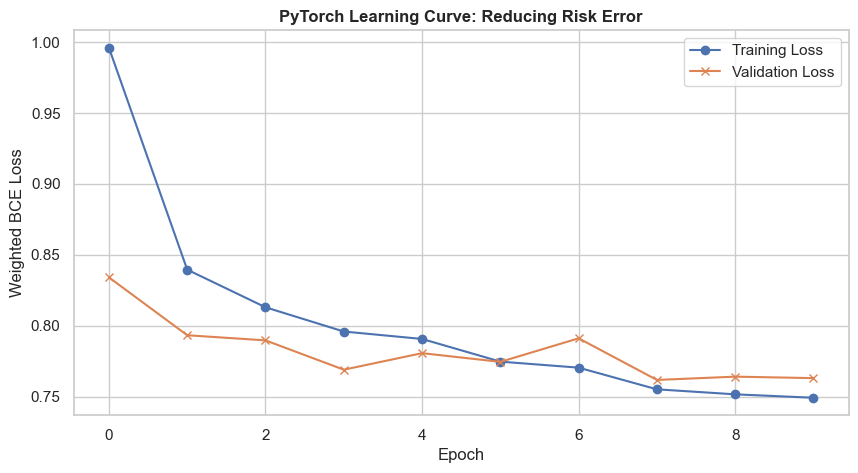

In [14]:
# ---------------------------------------------------------
#  Training Loop
# ---------------------------------------------------------
epochs = 10
train_losses = []
test_losses = []

print(f" Starting Training for {epochs} Epochs...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Batch Loop
    for x_c, x_n, y_batch in train_dl:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x_c, x_n)
        
        # Calculate Loss
        loss = criterion(y_pred, y_batch)
        
        # Backward pass (Learning)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # Calculate average loss for this epoch
    avg_train_loss = running_loss / len(train_dl)
    train_losses.append(avg_train_loss)
    
    # Evaluation (Validation Loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_c, x_n, y_batch in test_dl:
            y_pred = model(x_c, x_n)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_dl)
    test_losses.append(avg_val_loss)
    
    print(f"   Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print(" Training Complete.")

# Plot Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(test_losses, label='Validation Loss', marker='x')
plt.title('PyTorch Learning Curve: Reducing Risk Error', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Weighted BCE Loss')
plt.legend()
plt.savefig('../images/07_pytorch_learning_curve.png')
plt.show()


 PyTorch Challenger Report:
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      8957
         1.0       0.28      0.74      0.41       589

    accuracy                           0.87      9546
   macro avg       0.63      0.81      0.67      9546
weighted avg       0.94      0.87      0.89      9546

 PyTorch ROC-AUC: 0.8898


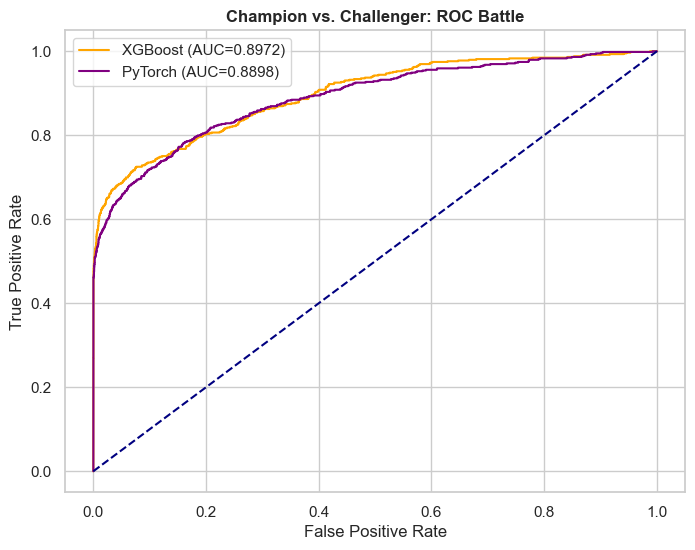

In [16]:
# ---------------------------------------------------------
#  Evaluate PyTorch Model
# ---------------------------------------------------------
model.eval() # Set to evaluation mode (turns off Dropout)

y_prob_list = []
y_true_list = []

with torch.no_grad():
    for x_c, x_n, y_batch in test_dl:
        # Get Logits
        logits = model(x_c, x_n)
        # Apply Sigmoid to get Probability (0-1)
        probs = torch.sigmoid(logits)
        
        y_prob_list.extend(probs.numpy().flatten())
        y_true_list.extend(y_batch.numpy().flatten())

# Convert to Numpy
y_probs_nn = np.array(y_prob_list)
y_true_nn = np.array(y_true_list)
y_pred_nn = (y_probs_nn >= 0.5).astype(int)

# 1. Classification Report
print("\n PyTorch Challenger Report:")
print(classification_report(y_true_nn, y_pred_nn))

# 2. ROC-AUC
auc_nn = roc_auc_score(y_true_nn, y_probs_nn)
print(f" PyTorch ROC-AUC: {auc_nn:.4f}")

# 3. Comparative ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_true_nn, y_probs_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'XGBoost (AUC={auc:.4f})') # Assuming 'fpr' from Cell 5 exists
plt.plot(fpr_nn, tpr_nn, color='purple', label=f'PyTorch (AUC={auc_nn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Champion vs. Challenger: ROC Battle', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('../images/08_model_comparison.png')
plt.show()

In [17]:
# ---------------------------------------------------------
# Save & Conclusion
# ---------------------------------------------------------
# Save PyTorch Model State
torch.save(model.state_dict(), '../models/pytorch_challenger.pth')
print(" PyTorch Model Saved to: ../models/pytorch_challenger.pth")

# Conclusion logic
if auc > auc_nn:
    print(f"\n WINNER: XGBoost Champion (AUC {auc:.4f} vs {auc_nn:.4f})")
    print("   We will use XGBoost for the Financial Optimization step.")
    winner = "XGBoost"
else:
    print(f"\n WINNER: PyTorch Challenger (AUC {auc_nn:.4f} vs {auc:.4f})")
    print("   Deep Learning outperformed Trees! We will use PyTorch.")
    winner = "PyTorch"

 PyTorch Model Saved to: ../models/pytorch_challenger.pth

 WINNER: XGBoost Champion (AUC 0.8972 vs 0.8898)
   We will use XGBoost for the Financial Optimization step.
